# LangGraph and LangSmith - Agentic RAG Powered by LangChain

In the following notebook we'll complete the following tasks:

- 🤝 Breakout Room #1:
  1. Install required libraries
  2. Set Environment Variables
  3. Creating our Tool Belt
  4. Creating Our State
  5. Creating and Compiling A Graph!

- 🤝 Breakout Room #2:
  1. Evaluating the LangGraph Application with LangSmith
  2. Adding Helpfulness Check and "Loop" Limits
  3. LangGraph for the "Patterns" of GenAI

# 🤝 Breakout Room #1

## Part 1: LangGraph - Building Cyclic Applications with LangChain

LangGraph is a tool that leverages LangChain Expression Language to build coordinated multi-actor and stateful applications that includes cyclic behaviour.

### Why Cycles?

In essence, we can think of a cycle in our graph as a more robust and customizable loop. It allows us to keep our application agent-forward while still giving the powerful functionality of traditional loops.

Due to the inclusion of cycles over loops, we can also compose rather complex flows through our graph in a much more readable and natural fashion. Effectively allowing us to recreate application flowcharts in code in an almost 1-to-1 fashion.

### Why LangGraph?

Beyond the agent-forward approach - we can easily compose and combine traditional "DAG" (directed acyclic graph) chains with powerful cyclic behaviour due to the tight integration with LCEL. This means it's a natural extension to LangChain's core offerings!

## Task 1:  Dependencies


## Task 2: Environment Variables

We'll want to set both our OpenAI API key and our LangSmith environment variables.

In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [2]:
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY")

### LOOM Note 
I am using this label "LOOM Note" to quickly find the spots in the notebook that I want to highlight in my LOOM video>


### LOOM Note
The google form for session 5 says: "Please provide a public URL to your GitHub Repo with both completed notebooks"
There's only this one notbook, right?
The ReadMe says:

Ship 🚢

The completed notebook!


### LOOM Note
I divided the next cell into multiple pieces, to better control wheter or not to create new UUID with every iteration

In [ ]:
from uuid import uuid4

# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = f"AIE7 - LangGraph - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")

In [ ]:
#Get a UUID and save it

todays_uuid = uuid4().hex[0:8]
print (todays_uuid)


6a7406d0


In [ ]:
# from uuid import uuid4

#Use the saved uuid

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE7 - LangGraph - {todays_uuid}"
print (os.environ ["LANGCHAIN_PROJECT"])
# os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")


AIE7 - LangGraph - 6a7406d0


## Task 3: Creating our Tool Belt

As is usually the case, we'll want to equip our agent with a toolbelt to help answer questions and add external knowledge.

There's a tonne of tools in the [LangChain Community Repo](https://github.com/langchain-ai/langchain-community/tree/main/libs/community) but we'll stick to a couple just so we can observe the cyclic nature of LangGraph in action!

We'll leverage:

- [Tavily Search Results](https://github.com/langchain-ai/langchain-community/blob/main/libs/community/langchain_community/tools/tavily_search/tool.py)
- [Arxiv](https://github.com/langchain-ai/langchain-community/blob/main/libs/community/langchain_community/tools/arxiv/tool.py)

### LOOM NOTE
#### 🏗️ Activity #1:

Please add the tools to use into our toolbelt.

> NOTE: Each tool in our toolbelt should be a method.

##### ✅ Answer
This is done in the next code cell:
tool_belt = [
    tavily_tool,
    ArxivQueryRun(),
]

In [15]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools.arxiv.tool import ArxivQueryRun

tavily_tool = TavilySearchResults(max_results=5)

tool_belt = [
    tavily_tool,
    ArxivQueryRun(),
]

/var/folders/xc/ddmjsd0x4sl7n58bhfwn6dv00000gn/T/ipykernel_24567/1203815797.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(max_results=5)


### Model

Now we can set-up our model! We'll leverage the familiar OpenAI model suite for this example - but it's not *necessary* to use with LangGraph. LangGraph supports all models - though you might not find success with smaller models - as such, they recommend you stick with:

- OpenAI's GPT-3.5 and GPT-4
- Anthropic's Claude
- Google's Gemini

> NOTE: Because we're leveraging the OpenAI function calling API - we'll need to use OpenAI *for this specific example* (or any other service that exposes an OpenAI-style function calling API.

In [16]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4.1-nano", temperature=0)

Now that we have our model set-up, let's "put on the tool belt", which is to say: We'll bind our LangChain formatted tools to the model in an OpenAI function calling format.

In [17]:
model = model.bind_tools(tool_belt)

In [52]:
type(model)

langchain_core.runnables.base.RunnableBinding

### LOOM NOTE
#### ❓ Question #1:

How does the model determine which tool to use?

##### ✅ Answer
The model object only knows about the tools that are defined (via: tool_belt =...) and then bound to the model (model.bind_tools...) 

When the model is invoked, the underlying LLM of the model makes the determination which tool to use, by "reasoning" (unless given specific instructions via a structured tool call). The LLM's reasoning is guided by tool metadata (e.g. names and descriptions) and by prompt context (which in our case is the content of the variable "messages".


## Task 4: Putting the State in Stateful

Earlier we used this phrasing:

`coordinated multi-actor and stateful applications`

So what does that "stateful" mean?

To put it simply - we want to have some kind of object which we can pass around our application that holds information about what the current situation (state) is. Since our system will be constructed of many parts moving in a coordinated fashion - we want to be able to ensure we have some commonly understood idea of that state.

LangGraph leverages a `StatefulGraph` which uses an `AgentState` object to pass information between the various nodes of the graph.

There are more options than what we'll see below - but this `AgentState` object is one that is stored in a `TypedDict` with the key `messages` and the value is a `Sequence` of `BaseMessages` that will be appended to whenever the state changes.

Let's think about a simple example to help understand exactly what this means (we'll simplify a great deal to try and clearly communicate what state is doing):

1. We initialize our state object:
  - `{"messages" : []}`
2. Our user submits a query to our application.
  - New State: `HumanMessage(#1)`
  - `{"messages" : [HumanMessage(#1)}`
3. We pass our state object to an Agent node which is able to read the current state. It will use the last `HumanMessage` as input. It gets some kind of output which it will add to the state.
  - New State: `AgentMessage(#1, additional_kwargs {"function_call" : "WebSearchTool"})`
  - `{"messages" : [HumanMessage(#1), AgentMessage(#1, ...)]}`
4. We pass our state object to a "conditional node" (more on this later) which reads the last state to determine if we need to use a tool - which it can determine properly because of our provided object!

In [18]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

## Task 5: It's Graphing Time!

Now that we have state, and we have tools, and we have an LLM - we can finally start making our graph!

Let's take a second to refresh ourselves about what a graph is in this context.

Graphs, also called networks in some circles, are a collection of connected objects.

The objects in question are typically called nodes, or vertices, and the connections are called edges.

Let's look at a simple graph.

![image](https://i.imgur.com/2NFLnIc.png)

Here, we're using the coloured circles to represent the nodes and the yellow lines to represent the edges. In this case, we're looking at a fully connected graph - where each node is connected by an edge to each other node.

If we were to think about nodes in the context of LangGraph - we would think of a function, or an LCEL runnable.

If we were to think about edges in the context of LangGraph - we might think of them as "paths to take" or "where to pass our state object next".

Let's create some nodes and expand on our diagram.

> NOTE: Due to the tight integration with LCEL - we can comfortably create our nodes in an async fashion!

In [19]:
from langgraph.prebuilt import ToolNode

def call_model(state):
  messages = state["messages"]
  response = model.invoke(messages)
  return {"messages" : [response]}

tool_node = ToolNode(tool_belt)

Now we have two total nodes. We have:

- `call_model` is a node that will...well...call the model
- `tool_node` is a node which can call a tool

Let's start adding nodes! We'll update our diagram along the way to keep track of what this looks like!


In [20]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(AgentState)

uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)

Let's look at what we have so far:

![image](https://i.imgur.com/md7inqG.png)

Next, we'll add our entrypoint. All our entrypoint does is indicate which node is called first.

In [21]:
uncompiled_graph.set_entry_point("agent")

![image](https://i.imgur.com/wNixpJe.png)

Now we want to build a "conditional edge" which will use the output state of a node to determine which path to follow.

We can help conceptualize this by thinking of our conditional edge as a conditional in a flowchart!

Notice how our function simply checks if there is a "function_call" kwarg present.

Then we create an edge where the origin node is our agent node and our destination node is *either* the action node or the END (finish the graph).

It's important to highlight that the dictionary passed in as the third parameter (the mapping) should be created with the possible outputs of our conditional function in mind. In this case `should_continue` outputs either `"end"` or `"continue"` which are subsequently mapped to the action node or the END node.

In [22]:
def should_continue(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  return END

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue
)

Let's visualize what this looks like.

![image](https://i.imgur.com/8ZNwKI5.png)

Finally, we can add our last edge which will connect our action node to our agent node. This is because we *always* want our action node (which is used to call our tools) to return its output to our agent!

In [54]:
uncompiled_graph.add_edge("action", "agent")

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


Let's look at the final visualization.

![image](https://i.imgur.com/NWO7usO.png)

All that's left to do now is to compile our workflow - and we're off!

In [24]:
simple_agent_graph = uncompiled_graph.compile()

### LOOM NOTE
#### Answer (note)
I added the cell below to see the generated graph
Not sure why the agent is showing as un-connected, but clearly it **is** connected, based on subsequent output.

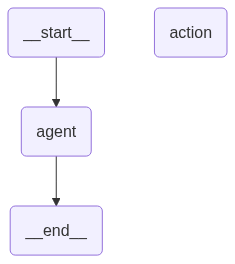

In [56]:

simple_agent_graph

### LOOM NOTE
#### ❓ Question #2:

Is there any specific limit to how many times we can cycle?
##### ✅ Answer
    Yes, according to the LangGraph documentation, the default is 25
    https://langchain-ai.github.io/langgraph/troubleshooting/errors/GRAPH_RECURSION_LIMIT/

If not, how could we impose a limit to the number of cycles?
##### ✅ Answer
Yes, the same way we do later in the notebook (Part 2, Task 3):
 if len(state["messages"]) > 10:
    return "END"

 Or by over-riding the recursion limit, like this example:
graph.invoke({...}, {"recursion_limit": 100})

## Using Our Graph

Now that we've created and compiled our graph - we can call it *just as we'd call any other* `Runnable`!

Let's try out a few examples to see how it fairs:

In [25]:
from langchain_core.messages import HumanMessage

inputs = {"messages" : [HumanMessage(content="Who is the current captain of the Winnipeg Jets?")]}

async for chunk in simple_agent_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_FDbwzkSM6p9T98OlzDGbibIx', 'function': {'arguments': '{"query":"current captain of the Winnipeg Jets"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 162, 'total_tokens': 185, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': None, 'id': 'chatcmpl-BsAnICRuqJJPWwjxZzKy21G9BNwEa', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--955f6068-6e12-4acf-bdc3-f37b80e2e514-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current captain of the Winnipeg Jets'}, 'id': 'call_FDbwzkSM6p9T98OlzDGbibIx', 'type': 

Let's look at what happened:

1. Our state object was populated with our request
2. The state object was passed into our entry point (agent node) and the agent node added an `AIMessage` to the state object and passed it along the conditional edge
3. The conditional edge received the state object, found the "tool_calls" `additional_kwarg`, and sent the state object to the action node
4. The action node added the response from the OpenAI function calling endpoint to the state object and passed it along the edge to the agent node
5. The agent node added a response to the state object and passed it along the conditional edge
6. The conditional edge received the state object, could not find the "tool_calls" `additional_kwarg` and passed the state object to END where we see it output in the cell above!

Now let's look at an example that shows a multiple tool usage - all with the same flow!

In [26]:
inputs = {"messages" : [HumanMessage(content="Search Arxiv for the QLoRA paper, then search each of the authors to find out their latest Tweet using Tavily!")]}

async for chunk in simple_agent_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        if node == "action":
          print(f"Tool Used: {values['messages'][0].name}")
        print(values["messages"])

        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qD1qcq42Vm0Jm4iQk6nv4FDA', 'function': {'arguments': '{"query": "QLoRA"}', 'name': 'arxiv'}, 'type': 'function'}, {'id': 'call_mY9gTdKJD0qan4x5aRZVqWnv', 'function': {'arguments': '{"query": "latest Tweet of the author of QLoRA"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 178, 'total_tokens': 236, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': None, 'id': 'chatcmpl-BsAvLdgtL1ymZnxDMsL50yw2NSUVo', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--69e555e8-e3f3-4a0b-b5c7-c3140c72981a-0', tool_calls=[{'name': 'arxiv', 

### LOOM note
#### 🏗️ Activity #2:

Please write out the steps the agent took to arrive at the correct answer.

### Answer for Activity 2
This might look like a long-winded reply, but instead, think of me as a ‘reasoning model’, or as we said in the old days, “show your work”:

This is my first draft, in my words:
1. Langgraph received update from node 'agent' that node agent decided to call 2 tools 
2. Langgraph recieved update from node action (toolMessage) that node action used tool arxiv, and here's what it found (article), and also used tool tavily, and here's what Tavily found (tweets) 
3. Langgraph received update from node 'agent' (AIMessage) with the summary 
4. Langgraph calls should continue and decides it is time to end, based on last message from agent (because there is not “tool call” in additional_kwarg

ChatGPT didn’t entirely approve of my words, but I didn’t like ChatGPT’s words, so I decided to try again using Wiz’s words:

#### Note

I think the model got lucky, because it called both tools simultaneously.
Tavily was called  with the query: {"query": "latest Tweet of the author of QLoRA"} So, even though ArXiv didn’t yet say who the authors were.
I saved this output in **“Activity2FirstRunOutput.md”**, so you can see that it matches my explanation (in case it behaves differently on the next run)

1. Our state object was populated with our request

2. The state object was passed into our entry point (agent node) and the agent node added an `AIMessage` to the state object and passed it along the conditional edge

3. The conditional edge received the state object, found the "tool_calls" `additional_kwarg`, and sent the state object to the action node, to call **both tools (simultaneously)**

4. The action node added the responses from **both ArXiv and Tavily** to the state object and passed it along the edge to the agent node

5. The agent node added a response to the state object and passed it along the conditional edge

6. The conditional edge received the state object, could not find the "tool_calls" `additional_kwarg` and passed the state object to END where we see it output in the cell above!

#### SO:
Tavilly still managed to answer the question, based on figuring out for itself who the authors were.

Lucky for the model, but not so lucky for me. Because **I think** the ***expected*** outcome was to demonstrate  additional cycles through the model, which I imaging would **probably** go something like this:

1. State object  populated with  request

2. The state object gets passed into our entry point (agent node) and the agent node adds an `AIMessage` to the state object and passes it along the conditional edge

3. The conditional edge receives the state object, finds the "tool_calls" `additional_kwarg`, and sends the state object to the action node, to call ArXiv


4. The action node adds the responses from  ArXiv  to the state object and passes it along the edge to the agent node

5. The agent node adds a response to the state object and passed it along the conditional edge

3. The conditional edge receives the state object, finds the "tool_calls" `additional_kwarg`, and sends the state object to the action node, to call Tavily, (with a query something like this: “"query": "latest Tweets of  Tim “Tim Dettmers, Artidoro Pagnoni, Ari Holtzman, and Luke Zettlemoyer”)


4. The action node adds the responses from Tavily  to the state object and passes it along the edge to the agent node

6. The conditional edge received the state object, does not find the "tool_calls" `additional_kwarg` and passes the state object to END where we see it output.


But that’s the thing about LLM’s they’re a bit **unpredictable** (I mean non-deterministic).

If I have time, I will try running it again, to see if I can get it to go the long-way around. Or, maybe try different prompts.

# 🤝 Breakout Room #2

## Part 1: LangSmith Evaluator

### Pre-processing for LangSmith

To do a little bit more preprocessing, let's wrap our LangGraph agent in a simple chain.

In [27]:
def convert_inputs(input_object):
  return {"messages" : [HumanMessage(content=input_object["question"])]}

def parse_output(input_state):
  return input_state["messages"][-1].content

agent_chain_with_formatting = convert_inputs | simple_agent_graph | parse_output

In [28]:
agent_chain_with_formatting.invoke({"question" : "What is RAG?"})

"RAG can refer to different concepts depending on the context. Could you please specify whether you're asking about RAG in the context of project management, machine learning, or another field?"

### Task 1: Creating An Evaluation Dataset

Just as we saw last week, we'll want to create a dataset to test our Agent's ability to answer questions.

In order to do this - we'll want to provide some questions and some answers. Let's look at how we can create such a dataset below.

```python
questions = [
    "What optimizer is used in QLoRA?",
    "What data type was created in the QLoRA paper?",
    "What is a Retrieval Augmented Generation system?",
    "Who authored the QLoRA paper?",
    "What is the most popular deep learning framework?",
    "What significant improvements does the LoRA system make?"
]

answers = [
    {"must_mention" : ["paged", "optimizer"]},
    {"must_mention" : ["NF4", "NormalFloat"]},
    {"must_mention" : ["ground", "context"]},
    {"must_mention" : ["Tim", "Dettmers"]},
    {"must_mention" : ["PyTorch", "TensorFlow"]},
    {"must_mention" : ["reduce", "parameters"]},
]
```

### LOOM Note
#### 🏗️ Activity #3:

Please create a dataset in the above format with at least 5 questions.

#### Answer for Activity #3: see python cell below (Pixar Questions)



In [57]:
#Pixar Questions
questions = [
    'What kind of toy is Woody in Toy Story?', 
    'What sport is central to the movie Cars?', 
    'What challenges does Marlin face on his journey in Finding Nemo?', 
    'How does WALL·E’s behavior change after meeting EVE?', 
    'What are the main themes explored in Inside Out?'
]

answers = [
    {'must_mention': ['cowboy']}, 
    {'must_mention': ['racing']}, 
    {'must_mention': ['ocean', 'Dory', 'search']}, 
    {'must_mention': ['EVE', 'love', 'follows']}, 
    {'must_mention': ['emotion', 'memory', 'growing up']}
]

In [29]:
questions = [
    "What optimizer is used in QLoRA?",
    "What data type was created in the QLoRA paper?",
    "What is a Retrieval Augmented Generation system?",
    "Who authored the QLoRA paper?",
    "What is the most popular deep learning framework?",
    "What significant improvements does the LoRA system make?"
]

answers = [
    {"must_mention" : ["paged", "optimizer"]},
    {"must_mention" : ["NF4", "NormalFloat"]},
    {"must_mention" : ["ground", "context"]},
    {"must_mention" : ["Tim", "Dettmers"]},
    {"must_mention" : ["PyTorch", "TensorFlow"]},
    {"must_mention" : ["reduce", "parameters"]},
]

### LOOM Note
Now we can add our dataset to our LangSmith project using the following code which we saw last Thursday!

In [65]:
from langsmith import Client

client = Client()

# dataset_name = f"Retrieval Augmented Generation - Evaluation Dataset - {uuid4().hex[0:8]}"
# dataset_name = f"Retrieval Augmented Generation - Evaluation Dataset - {todays_uuid}"
dataset_name = f"Pixar Questions - Evaluation Dataset - {uuid4().hex[0:8]}"

# dataset = client.create_dataset(
#     dataset_name=dataset_name,
#     description="Questions about the QLoRA Paper to Evaluate RAG over the same paper."
# )

dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Questions about Pixar Movies."
)
client.create_examples(
    inputs=[{"question" : q} for q in questions],
    outputs=answers,
    dataset_id=dataset.id,
)


{'example_ids': ['d00c311b-4e9b-41b6-b816-8838f680df98',
  '16caeb72-2434-4424-be29-d8adb004c78f',
  '089669f0-958d-4a82-801a-a298f5934d35',
  '3df2c5cd-da96-4811-8e45-84a25a952e9c',
  '55b03403-df5e-43cd-834b-3d7cedc81dbe'],
 'count': 5}

#### ❓ Question #3:

How are the correct answers associated with the questions?


##### ✅ Answer Part 1

At first glance, this seemed a simple enough question, and my simple answer is that the langsmith function client.create_examples matches each input list item to the correspondingly indexed item in the output list.

#### Answer Part 2
However, that answer seemed too simple for what you wanted, so I tried to answer **how** the create_examples function do the matching. 
I went to the LangSmith documentation here: https://docs.smith.langchain.com/reference/python/client/langsmith.client.Client#langsmith.client.Client.create_examples 
and then to the source code here:  https://docs.smith.langchain.com/reference/python/_modules/langsmith/client#Client.create_examples

where I found the below hideous-looking-but-probably-elegantly-constructed nested list comprehension which does some validatoin to see which keyword arguments exist and then matches them up appropriately, using a python function called zip. 

While the first answer seemed too simple, this answer seemed more complicated than you wanted.
Let me know if it isn't the most thorough answer you get 🤓

ls_schemas.ExampleCreate(
                    **{
                        "inputs": in_,
                        "outputs": out_,
                        "metadata": metadata_,
                        "split": split_,
                        "id": id_ or str(uuid.uuid4()),
                        "source_run_id": source_run_id_,
                    }
                )
                for in_, out_, metadata_, split_, id_, source_run_id_ in zip(
                    inputs,
                    kwargs.get("outputs") or (None for _ in range(input_len)),
                    kwargs.get("metadata") or (None for _ in range(input_len)),
                    kwargs.get("splits") or (None for _ in range(input_len)),
                    kwargs.get("ids") or (None for _ in range(input_len)),
                    kwargs.get("source_run_ids") or (None for _ in range(input_len)),

### LOOM Note
> NOTE: Feel free to indicate if this is problematic or not

#### Answer Part 3

Matching question to answer by index position is cumbersome and not scalable (thanks to the Wiz for pointing out in office hours that this is why you asked the question)

### Task 2: Adding Evaluators

Now we can add a custom evaluator to see if our responses contain the expected information.

We'll be using a fairly naive exact-match process to determine if our response contains specific strings.

In [66]:
from langsmith.evaluation import EvaluationResult, run_evaluator

@run_evaluator
def must_mention(run, example) -> EvaluationResult:
    prediction = run.outputs.get("output") or ""
    required = example.outputs.get("must_mention") or []
    score = all(phrase in prediction for phrase in required)
    return EvaluationResult(key="must_mention", score=score)

#### ❓ Question #4:

What are some ways you could improve this metric as-is?

##### ✅ Answer #4
We could check for semantic similarity (e.g. using embeddings and cosine similarity) between the result and the targeted words, instead of requiring an exact match.

We can also use something like the helpfulness code (below) to decide when the answer is close enough before giving a final response (that might improve the output, but it doesn't actually change the metric)

> NOTE: Alternatively you can suggest where gaps exist in this method.

### LOOM Note
Gaps: the must_mention rubric is very rigid, and doesn't make allowances for close match. (on the positive side, it is more objective than some of the evals we did last week)

I got several answers which were clearly correct, but failed. because they didn't exactly match all the words. 
For example a question in my Pixar data set, got this answer
> "Inside Out" explores several main themes, including the importance of understanding and expressing emotions,  
> the complexity of human feelings, the significance of emotional balance, and the value of memories in shaping identity.  
> It also emphasizes the idea that all emotions, even the seemingly negative ones, have a vital role in personal growth and well-being.  
> Would you like a more detailed analysis of these themes?

which failed even though it included "emotions" (but not emotion), "memories" (but not memory), and "personal growth" (but not growing up)



Task 3: Evaluating

All that is left to do is evaluate our agent's response!

In [67]:
experiment_results = client.evaluate(
    agent_chain_with_formatting,
    data=dataset_name,
    evaluators=[must_mention],
    experiment_prefix=f"Search Pipeline - Evaluation - {uuid4().hex[0:4]}",
    metadata={"version": "1.0.0"},
)

View the evaluation results for experiment: 'Search Pipeline - Evaluation - 2532-78e01c39' at:
https://smith.langchain.com/o/6a26aaa0-1b14-4cdb-933f-5cb4da328a84/datasets/c1b33179-9a93-45af-9075-1088492065d8/compare?selectedSessions=b0189946-994b-466a-b739-6e7d76047de5




0it [00:00, ?it/s]

In [ ]:
experiment_results

<ExperimentResults Search Pipeline - Evaluation - 434e-5adce54a>


## Part 2: LangGraph with Helpfulness:

### Task 3: Adding Helpfulness Check and "Loop" Limits

Now that we've done evaluation - let's see if we can add an extra step where we review the content we've generated to confirm if it fully answers the user's query!

We're going to make a few key adjustments to account for this:

1. We're going to add an artificial limit on how many "loops" the agent can go through - this will help us to avoid the potential situation where we never exit the loop.
2. We'll add to our existing conditional edge to obtain the behaviour we desire.

First, let's define our state again - we can check the length of the state object, so we don't need additional state for this.

In [41]:
class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

Now we can set our graph up! This process will be almost entirely the same - with the inclusion of one additional node/conditional edge!

#### 🏗️ Activity #5: <-- Activities numbered weirdly

Please write markdown for the following cells to explain what each is doing.

### LOOM Note
##### YOUR MARKDOWN HERE
The next cell adds nodes for agent and action

In [42]:
graph_with_helpfulness_check = StateGraph(AgentState)

graph_with_helpfulness_check.add_node("agent", call_model)
graph_with_helpfulness_check.add_node("action", tool_node)

##### YOUR MARKDOWN HERE
The next cell adds the entrypoint. (The entrypoint indicates which node is called first.)

In [43]:
graph_with_helpfulness_check.set_entry_point("agent")

##### YOUR MARKDOWN HERE
The next cell defines the helper function tool_call_or_helpful


In [44]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

def tool_call_or_helpful(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  initial_query = state["messages"][0]
  final_response = state["messages"][-1]

  if len(state["messages"]) > 10:
    return "END"

  prompt_template = """\
  Given an initial query and a final response, determine if the final response is extremely helpful or not. Please indicate helpfulness with a 'Y' and unhelpfulness as an 'N'.

  Initial Query:
  {initial_query}

  Final Response:
  {final_response}"""

  helpfullness_prompt_template = PromptTemplate.from_template(prompt_template)

  helpfulness_check_model = ChatOpenAI(model="gpt-4.1-mini")

  helpfulness_chain = helpfullness_prompt_template | helpfulness_check_model | StrOutputParser()

  helpfulness_response = helpfulness_chain.invoke({"initial_query" : initial_query.content, "final_response" : final_response.content})

  if "Y" in helpfulness_response:
    return "end"
  else:
    return "continue"

#### 🏗️ Activity #4:

Please write what is happening in our `tool_call_or_helpful` function!

#### Answer Activity #4
This function evaluates criteria to determine whether the agent step will lead to a next state of action, end, or back to agent (continue)

In more detail:
This helper function will serve as a 'conditional edge', aka decision point
It is similar to the 'should_continue' edge from the earlier exercise
Similar to 'should_continue', if the last_message contains a tool call, it will return "action" (which will cause another tool call)
But, now we have additional conditions
It returns "end" if there have been more than 10 attempts
If neither of those conditions happen, it creates a prompt template, and calls the LLM (gpt-4.1-mini) (via the helpfulness_chain)
Based on the guidance from the prompt template, the LLM **judges** whether the current tool response is *good enough* to answer the initial query ("helpful"). The outcome of this chain drive another branch determing whether to return "continue", or "end" 




##### YOUR MARKDOWN HERE

The next cell adds the above (tool_call_or_helpful) function to the graph as a conditional edge 

In [45]:
graph_with_helpfulness_check.add_conditional_edges(
    "agent",
    tool_call_or_helpful,
    {
        "continue" : "agent",
        "action" : "action",
        "end" : END
    }
)

##### YOUR MARKDOWN HERE

The next cell adds a (not conditional) edge to the graph, connecting action to agent
This is because we *always* want our action node (which is used to call our tools) to return its output to our agent!

In [46]:
graph_with_helpfulness_check.add_edge("action", "agent")

##### YOUR MARKDOWN HERE
The next cell compiles the workflow.

In [47]:
agent_with_helpfulness_check = graph_with_helpfulness_check.compile()

##### YOUR MARKDOWN HERE
The next cell executes the graph, with a question (HumanMessage") and prints the output.

In [48]:
inputs = {"messages" : [HumanMessage(content="Related to machine learning, what is LoRA? Also, who is Tim Dettmers? Also, what is Attention?")]}

async for chunk in agent_with_helpfulness_check.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7usXLqtnVxrxAcJSKhh2Z5HE', 'function': {'arguments': '{"query": "LoRA machine learning"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_PcMr34CWmchA6CAirZNTOxen', 'function': {'arguments': '{"query": "Tim Dettmers"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_UPTj5MqfKCH55Axgx7lV8rR8', 'function': {'arguments': '{"query": "Attention in machine learning"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 177, 'total_tokens': 256, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': None, 'id': 'chatcmpl-BsB

### Task 4: LangGraph for the "Patterns" of GenAI

Let's ask our system about the 4 patterns of Generative AI:

1. Prompt Engineering
2. RAG
3. Fine-tuning
4. Agents

In [49]:
patterns = ["prompt engineering", "RAG", "fine-tuning", "LLM-based agents"]

In [50]:
for pattern in patterns:
  what_is_string = f"What is {pattern} and when did it break onto the scene??"
  inputs = {"messages" : [HumanMessage(content=what_is_string)]}
  messages = agent_with_helpfulness_check.invoke(inputs)
  print(messages["messages"][-1].content)
  print("\n\n")

Prompt engineering is the process of designing and refining input prompts to effectively communicate with AI language models, such as GPT, to elicit accurate, relevant, and useful responses. It involves crafting prompts that guide the model's output in a desired direction, often through techniques like specifying context, framing questions clearly, or using structured formats.

Prompt engineering has become increasingly prominent with the rise of large language models (LLMs) around 2020 and 2021, as these models gained widespread attention for their ability to generate human-like text. The practice gained significant traction as users and developers sought ways to optimize the performance of these models for various applications, leading to the emergence of prompt engineering as a specialized skill.

Would you like me to find more detailed historical information or recent developments related to prompt engineering?



RAG, which stands for Retrieval-Augmented Generation, is a technique

### LOOM Note
I added below cell to see the graph

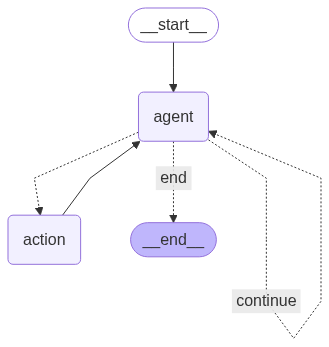

In [51]:
agent_with_helpfulness_check